In [18]:
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import torch.nn as nn

import numpy as np
import cv2

import os.path as osp
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader


#from data import NucleusDataset, Rescale, ToTensor, Normalize
#from model import UNet

In [19]:
class ToTensor:
    def __call__(self, data):
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        elif len(data.shape) == 3:
            data = data.transpose((2, 0, 1))
        else:
            print("Unsupported shape!")
        return torch.from_numpy(data)

In [20]:
class Normalize:
    def __call__(self, image):
        image = image.astype(np.float32) / 255
        return image

In [21]:
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return cv2.resize(image, (self.output_size, self.output_size), cv2.INTER_AREA)

In [22]:
class UNet(nn.Module):
    def __init__(self, kernel_size=3, padding=1):
        super(UNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=kernel_size, padding=padding)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding)
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=kernel_size, padding=padding)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=kernel_size, padding=padding)
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=kernel_size, padding=padding)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=kernel_size, padding=padding)
        self.conv5_t = nn.ConvTranspose2d(512, 256, 2, stride=2)

        self.conv6_1 = nn.Conv2d(512, 256, kernel_size=kernel_size, padding=padding)
        self.conv6_2 = nn.Conv2d(256, 256, kernel_size=kernel_size, padding=padding)
        self.conv6_t = nn.ConvTranspose2d(256, 128, 2, stride=2)

        self.conv7_1 = nn.Conv2d(256, 128, kernel_size=kernel_size, padding=padding)
        self.conv7_2 = nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding)
        self.conv7_t = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.conv8_1 = nn.Conv2d(128, 64, kernel_size=kernel_size, padding=padding)
        self.conv8_2 = nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding)
        self.conv8_t = nn.ConvTranspose2d(64, 32, 2, stride=2)

        self.conv9_1 = nn.Conv2d(64, 32, kernel_size=kernel_size, padding=padding)
        self.conv9_2 = nn.Conv2d(32, 32, kernel_size=kernel_size, padding=padding)

        self.conv10 = nn.Conv2d(32, 1, kernel_size=kernel_size, padding=padding)

    def forward(self, x):
        conv1 = F.relu(self.conv1_1(x))
        conv1 = F.relu(self.conv1_2(conv1))
        pool1 = self.maxpool1(conv1)

        conv2 = F.relu(self.conv2_1(pool1))
        conv2 = F.relu(self.conv2_2(conv2))
        pool2 = self.maxpool2(conv2)

        conv3 = F.relu(self.conv3_1(pool2))
        conv3 = F.relu(self.conv3_2(conv3))
        pool3 = self.maxpool3(conv3)

        conv4 = F.relu(self.conv4_1(pool3))
        conv4 = F.relu(self.conv4_2(conv4))
        pool4 = self.maxpool4(conv4)

        conv5 = F.relu(self.conv5_1(pool4))
        conv5 = F.relu(self.conv5_2(conv5))

        up6 = torch.cat((self.conv5_t(conv5), conv4), dim=1)
        conv6 = F.relu(self.conv6_1(up6))
        conv6 = F.relu(self.conv6_2(conv6))

        up7 = torch.cat((self.conv6_t(conv6), conv3), dim=1)
        conv7 = F.relu(self.conv7_1(up7))
        conv7 = F.relu(self.conv7_2(conv7))

        up8 = torch.cat((self.conv7_t(conv7), conv2), dim=1)
        conv8 = F.relu(self.conv8_1(up8))
        conv8 = F.relu(self.conv8_2(conv8))

        up9 = torch.cat((self.conv8_t(conv8), conv1), dim=1)
        conv9 = F.relu(self.conv9_1(up9))
        conv9 = F.relu(self.conv9_2(conv9))
        
        return torch.sigmoid(self.conv10(conv9))
        #return F.sigmoid(self.conv10(conv9))

In [23]:
model_temp = UNet()
print(model_temp)

UNet(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [24]:
class NucleusDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        datafldr = "images"
        maskfldr ="masks"

        if not self._check_exists():
            raise RuntimeError("Dataset not found.")

        if self.train:
            print("root_dir :",str(root_dir))
            #self.image_names = os.listdir(osp.join(self.root_dir, "train"))
            self.image_names = os.listdir(os.path.join(self.root_dir, datafldr))
            print("train image_names :",self.image_names)
            self.train_data = []
            self.train_labels = []

            for image_name in tqdm(self.image_names):
                train_img = cv2.imread(osp.join(self.root_dir, datafldr, image_name, "images", image_name + ".png"))
                #train_img = cv2.imread(osp.join(self.root_dir, "train",image_name))

                self.train_data.append(train_img)

                target_img = np.zeros(train_img.shape[:2], dtype=np.uint8)
                for target in glob(osp.join(self.root_dir, "train", image_name, "masks", "*.png")):
                    target_img_ = cv2.imread(target, 0)
                    target_img = np.maximum(target_img, target_img_)

                self.train_labels.append(target_img)
        else:
            self.image_names = os.listdir(osp.join(self.root_dir, "test"))
            self.test_data = []
            #print("test image_names :",self.image_names)

            for image_name in tqdm(self.image_names):
                test_img = cv2.imread(osp.join(self.root_dir, "test", image_name, "images", image_name + ".png"))
                #test_img = cv2.imread(osp.join(self.root_dir, "test", image_name))  

                self.test_data.append(test_img)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, item):
        if self.train:
            image, mask = self.train_data[item], self.train_labels[item]

            if self.transform:
                image = self.transform(image)

            if self.target_transform:
                mask = self.target_transform(mask)

            return image, mask
        else:
            image = self.test_data[item]

            if self.transform:
                image = self.transform(image)

            return image

    def _check_exists(self):
        return osp.exists(osp.join(self.root_dir, "train")) and osp.exists(osp.join(self.root_dir, "test"))

In [30]:
class NucleusDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        if not self._check_exists():
            raise RuntimeError("Dataset not found.")

        if self.train:
            print("root_dir :",str(root_dir))
            #self.image_names = os.listdir(osp.join(self.root_dir, "train"))
            self.image_names = os.listdir(os.path.join(self.root_dir, "train"))
            #print("train image_names :",self.image_names)
            self.train_data = []
            self.train_labels = []

            for image_name in tqdm(self.image_names):
                train_img = cv2.imread(osp.join(self.root_dir, "train", image_name, "images", image_name + ".png"))
                #train_img = cv2.imread(osp.join(self.root_dir, "train",image_name))

                self.train_data.append(train_img)

                target_img = np.zeros(train_img.shape[:2], dtype=np.uint8)
                for target in glob(osp.join(self.root_dir, "train", image_name, "masks", "*.png")):
                    target_img_ = cv2.imread(target, 0)
                    target_img = np.maximum(target_img, target_img_)

                self.train_labels.append(target_img)
        else:
            self.image_names = os.listdir(osp.join(self.root_dir, "test"))
            self.test_data = []
            #print("test image_names :",self.image_names)

            for image_name in tqdm(self.image_names):
                test_img = cv2.imread(osp.join(self.root_dir, "test", image_name, "images", image_name + ".png"))
                #test_img = cv2.imread(osp.join(self.root_dir, "test", image_name))  

                self.test_data.append(test_img)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, item):
        if self.train:
            image, mask = self.train_data[item], self.train_labels[item]

            if self.transform:
                image = self.transform(image)

            if self.target_transform:
                mask = self.target_transform(mask)

            return image, mask
        else:
            image = self.test_data[item]

            if self.transform:
                image = self.transform(image)

            return image

    def _check_exists(self):
        return osp.exists(osp.join(self.root_dir, "train")) and osp.exists(osp.join(self.root_dir, "test"))

In [31]:
def train(epochs, batch_size, learning_rate,root_dir):
    train_loader = torch.utils.data.DataLoader(
        NucleusDataset(root_dir, train=True,
                       transform=transforms.Compose([
                           Normalize(),
                           Rescale(_imageSize),
                           ToTensor()
                       ]),
                       target_transform=transforms.Compose([
                           Normalize(),
                           Rescale(_imageSize),
                           ToTensor()
                       ])),
        batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        running_loss = 0.0
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            print("images shape :",images.shape ,"masks shape:",masks.shape)
            
            optimizer.zero_grad()

            output = model(images)
            print("output shape :",images.shape ,"input images shape : ", images.shape)
 
            loss = F.binary_cross_entropy(output, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print("Loss: {:.4f}\n".format(epoch_loss))

    os.makedirs("models", exist_ok=True)
    torch.save(model, "models/model.pt")

In [35]:
#img_root_dir ="E:/IIITB/Documents/data/Dataset"

In [36]:
img_root_dir = "D:/MedicalImageProcessing/MedicalImaging/Nuclei-segmentation-master_mod/Nuclei-segmentation-master/data"

In [37]:
_figSize = 80
_fontSize = 60
_imageSize= 256
_learningRate = 0.001
_batchSize = 1
_epoch=1

In [38]:
train(epochs=_epoch,
          batch_size=_batchSize,
          learning_rate=_learningRate,root_dir=img_root_dir)

root_dir : D:/MedicalImageProcessing/MedicalImaging/Nuclei-segmentation-master_mod/Nuclei-segmentation-master/data


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [01:45<00:00,  6.33it/s]


Epoch 1/1
----------
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1,

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output shape : torch.Size([1, 3, 256, 256]) input images shape :  torch.Size([1, 3, 256, 256])
images shape : torch.Size([1, 3, 256, 256]) masks shape: torch.Size([1, 1, 256, 256])
output sh

C:\Users\Sukanya\Anaconda3\envs\nn_net\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
def show_images(images, masks, columns=6):
    fig = plt.figure()
    rows = np.ceil((images.shape[0] + masks.shape[0]) / columns)
    index = 1
    for image, mask in zip(images, masks):
        f1 = fig.add_subplot(rows, columns, index)
        f1.set_title('input')
        plt.axis('off')
        plt.imshow(image)
        index += 1

        f2 = fig.add_subplot(rows, columns, index)
        f2.set_title('prediction')
        plt.axis('off')
        plt.imshow(mask)
        index += 1

    plt.show()

In [12]:
def show_images(images, masks, columns=4):
    fig = plt.figure(figsize=(_figSize,_figSize))
    rows = np.ceil((images.shape[0] + masks.shape[0]) / columns)
    index = 1
    for image, mask in zip(images, masks):
        f1 = fig.add_subplot(rows, columns, index)
        f1.set_title('input', fontsize = _fontSize)
        plt.axis('off')
        plt.imshow(image)
        index += 1

        f2 = fig.add_subplot(rows, columns, index)
        f2.set_title('prediction',fontsize = _fontSize)
        plt.axis('off')
        plt.imshow(mask)
        index += 1

    plt.show()

In [13]:
def tensor_to_numpy(tensor):
    t_numpy = tensor.cpu().numpy()
    t_numpy = np.transpose(t_numpy, [0, 2, 3, 1])
    t_numpy = np.squeeze(t_numpy)

    return t_numpy

In [14]:
def test():
    test_img_root_dir ="D:/MedicalImageProcessing/MedicalImaging/Nuclei-segmentation-master_mod/Nuclei-segmentation-master/data"
    test_loader = DataLoader(NucleusDataset(test_img_root_dir,
                                            train=False,
                                            transform=transforms.Compose([
                                                Normalize(),
                                                Rescale(_imageSize),
                                                ToTensor()])),
                             batch_size=10,
                             shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = torch.load("models/model.pt")
    model.eval()
    model.to(device)

    with torch.no_grad():
        images = next(iter(test_loader)).to(device)

        outputs = model(images)

        images = tensor_to_numpy(images)
        outputs = tensor_to_numpy(outputs)

        show_images(images, outputs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 54.69it/s]


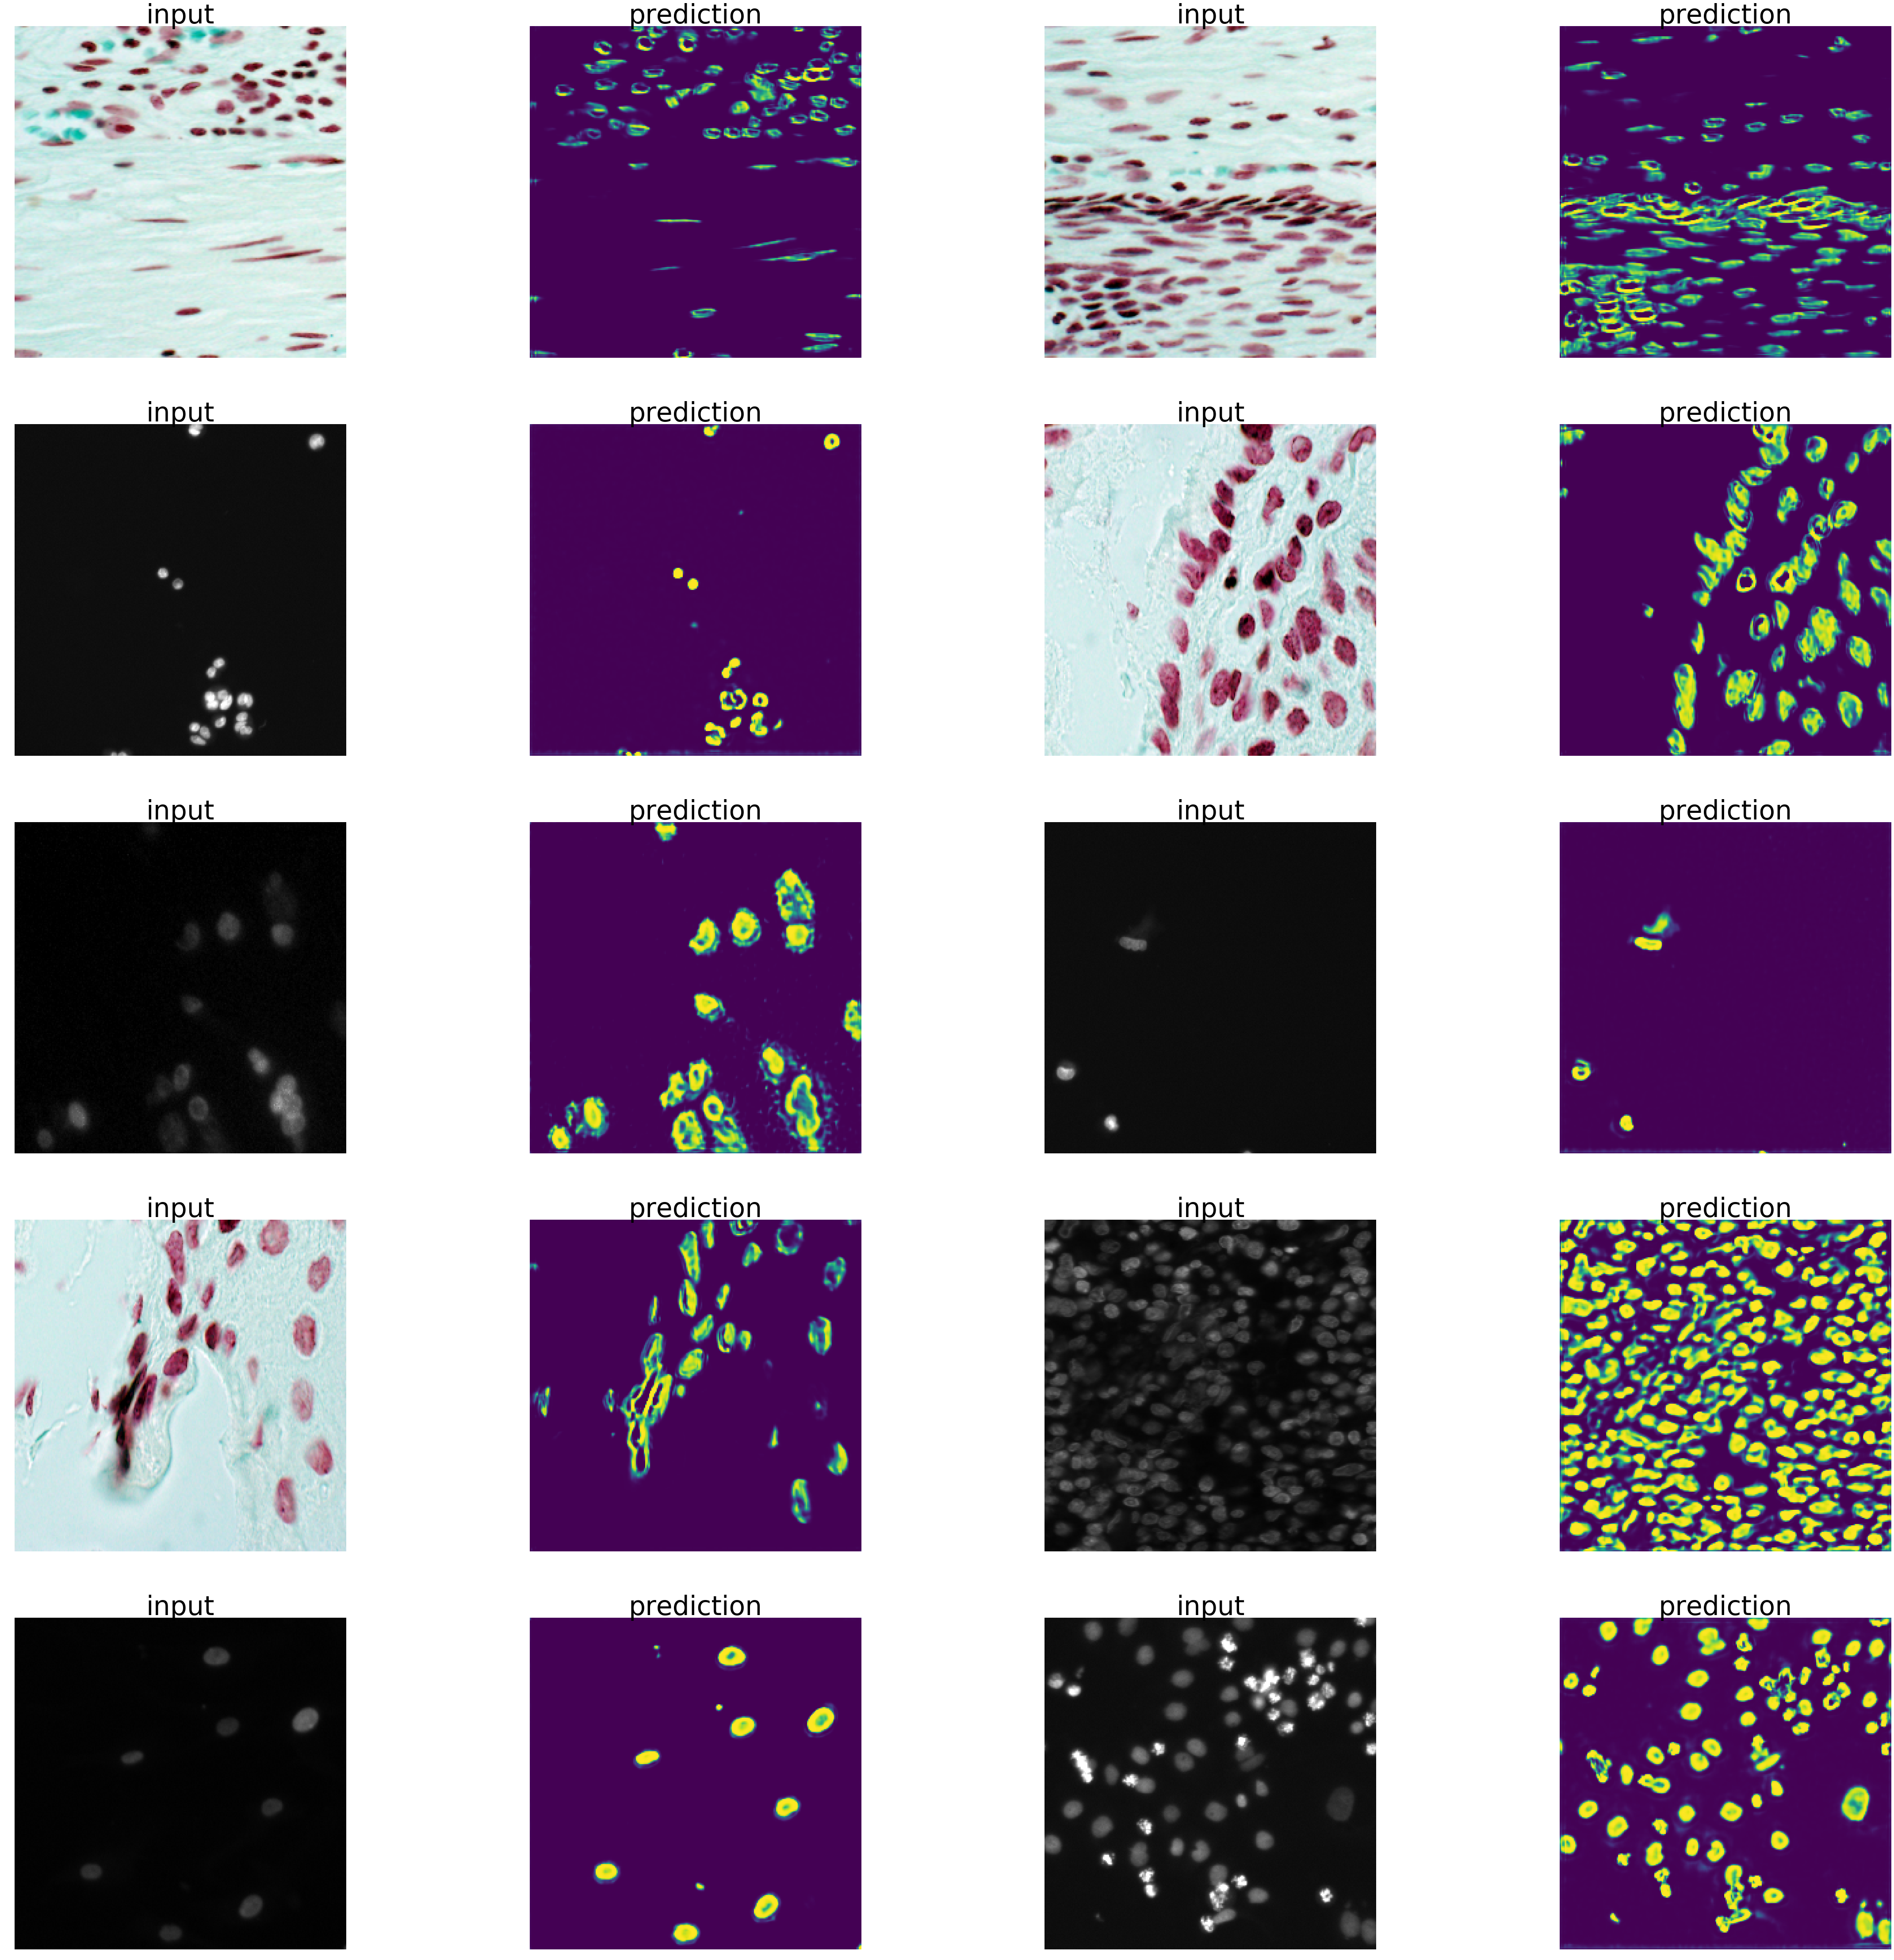

In [15]:
test()